In [1]:
#Importing required modules
import keras
import numpy as np
import pandas as pd
import seaborn as sns
from math import ceil
from keras import Sequential
from keras.layers import Dense
from sklearn import model_selection
pd.plotting.register_matplotlib_converters()
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

Using TensorFlow backend.


# Data Exploration & Cleaning

In [2]:
data = pd.read_csv('SBAnational.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#first 5 entries in data.
data.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [4]:
#columns (variables) in the dataset.
columns = data.columns
print(columns)

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')


In [5]:
#dimensions of the data
print('Rows : ', data.shape[0])
print('Columns : ', data.shape[1])

Rows :  899164
Columns :  27


## Missing Values
### *Finding missing values as the percentage of the total entries*.

In [6]:
#computing the total missing values in each column.
total = data.isnull().sum().sort_values(ascending = False)
#converting in percentage.
percent = (total/data.shape[0])*100
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
#printing only those columns which have missing values.
print(missing_data[missing_data.Percent > 0])

                   Total    Percent
ChgOffDate        736465  81.905526
RevLineCr           4528   0.503579
LowDoc              2582   0.287156
DisbursementDate    2368   0.263356
MIS_Status          1997   0.222095
BankState           1566   0.174162
Bank                1559   0.173383
NewExist             136   0.015125
City                  30   0.003336
Name                  14   0.001557
State                 14   0.001557


### As the column *'ChgOffDate'*  has considerably high number of missing values, thus we'll drop this columns. Other columns have insignificant number of missing values ( even less than 1% ), so we'll just remove the corresponding entries rather than removing the columns.

In [7]:
#removing the 'ChgoOffDate' column
data.drop('ChgOffDate', axis = 1, inplace = True)

In [8]:
#dropping the rows containing a missing value in any column.
data.dropna(inplace = True)

In [9]:
#reseting the indices.
data.reset_index(inplace = True, drop = True)

In [10]:
data.describe()

,LoanNr_ChkDgt,Zip,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural
count,8.862400e+05,886240.000000,886240.000000,886240.000000,886240.000000,886240.000000,886240.000000,886240.000000,886240.000000,886240.000000
mean,4.764531e+09,53863.829072,399251.824562,110.954647,11.420650,1.279900,8.463092,10.842406,2762.323810,0.759725
std,2.539319e+09,31183.864500,263211.592441,78.990583,74.187995,0.451509,237.301746,237.739546,12776.276419,0.646074
min,1.000014e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.577612e+09,27610.000000,235310.000000,60.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,4.351670e+09,55416.000000,445310.000000,84.000000,4.000000,1.000000,0.000000,1.000000,1.000000,1.000000
75%,6.878439e+09,83709.000000,561740.000000,120.000000,10.000000,2.000000,1.000000,4.000000,1.000000,1.000000
max,9.996003e+09,99999.000000,928120.000000,569.000000,9999.000000,2.000000,8800.000000,9500.000000,99999.000000,2.000000


## Extracting the Industry code from the NAICS codes
### The first two digits of the North American Industry Classification System (NAICS) denote the Industry the particular business establishement belongs to. 
### Sector Description
#### 11 Agriculture, forestry, fishing and hunting
#### 21 Mining, quarrying, and oil and gas extraction
#### 22 Utilities
#### 23 Construction
#### 31–33 Manufacturing
#### 42 Wholesale trade
#### 44–45 Retail trade
#### 48–49 Transportation and warehousing
#### 51 Information
#### 52 Finance and insurance
#### 53 Real estate and rental and leasing
#### 54 Professional, scientific, and technical services
#### 55 Management of companies and enterprises
#### 56 Administrative and support and waste management and remediation services
#### 61 Educational services
#### 62 Health care and social assistance
#### 71 Arts, entertainment, and recreation
#### 72 Accommodation and food services
#### 81 Other services (except public administration) 92 Public administration
### Hence extracting the first two digits.

In [11]:
#a function 'extract' to extract the first 2 digits of the NAICS code.
def extract(x):
    if(x > 0):
        digits = str(x)[0:2]
        return int(digits)
    return 0

In [12]:
#getting the NAICS entry for each row
code = data.NAICS.values
for i in range(len(code)):
    #changing and saving the code in a list
    code[i] = extract(code[i])

In [13]:
#updating the NAICS column with extracted codes.
data.NAICS = code
data.NAICS

0         45
1         72
2         62
3          0
4          0
          ..
886235    45
886236    45
886237    33
886238     0
886239     0
Name: NAICS, Length: 886240, dtype: int64

In [14]:
#a function to calculate the default rate respective
def changer(data, list_, dicti, col):
    for i in list_:
        #getting the total number of loans
        total = data[data[col] == i].shape[0]
        #getting the "default" loans
        defaults = data[(data[col] == i) & (data.MIS_Status == "CHGOFF")].shape[0]
        #saving the percentage
        dicti[i] = (defaults/total)*100.00
    return data

### Replacing the NAICS industry codes with their respective default rate.

In [15]:
#getting all the unique values in the NAICS column
indus = (data.NAICS.unique())

#a dictionary for mapping the industry code to default rate
indus_def = {}

data = changer(data, indus, indus_def, 'NAICS')

In [16]:
#changing the values
for i in indus_def:
    data.loc[data.NAICS == i, 'NAICS'] = indus_def[i]

## State and BankState

### Instead of considering the name of states, replacing the states with the respective default rate.

In [17]:
#getting all the unique values in the columns 'State' and 'BankState'
states = (data.State.unique())
Bstates = (data.BankState.unique())

#Dictionaries to map state with respective default rate
state_def = {}
Bstate_def = {}

data = changer(data, states, state_def, 'State')
data = changer(data, Bstates, Bstate_def, 'BankState')

In [18]:
#changing the values

#in the State column
for i in state_def:
    data.loc[data.State == i, 'State'] = state_def[i]

#in the BankState column
for j in Bstate_def:
    data.loc[data.BankState == j, 'BankState'] = Bstate_def[j]

## RealEstate
### Since the term of loan is a function of expected life - time of the assests, so considering the loans with term of more than 240 months to be backed by RealEstate.

In [19]:
#appending a new column for RealEstate
data['RealEstate'] = np.array(data.Term >= 240, dtype = int)

## NewExist

### According to the documentation there should be only two values in NewExist i.e. 1 (Existing business) or 2 (New business) .

In [20]:
print(data.NewExist.value_counts())

1.0    636139
2.0    249080
0.0      1021
Name: NewExist, dtype: int64


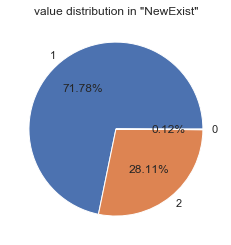

In [21]:
#getting count of values in the column 
values = data.NewExist.value_counts().to_numpy()

#providing labels
labels = ['1', '2', '0']

#plotting a pie chart
plt.pie(x = values, labels = labels, autopct = '%.2f%%')
plt.title('value distribution in "NewExist"')
plt.show()

### From the above plot it is evident that there are very less rows corresponding to 0 labels. Hence dropping the rows with 0 labels.

In [22]:
data.drop(data[data.NewExist == 0].index, inplace = True)
data.reset_index(inplace = True, drop = True)

## CreateJob

In [23]:
data.CreateJob.value_counts()

0       618973
1        62267
2        57034
3        28447
4        20232
         ...  
171          1
169          1
166          1
164          1
1530         1
Name: CreateJob, Length: 245, dtype: int64

### Visualizing the value share between zero and non zero values in 'CreateJob'

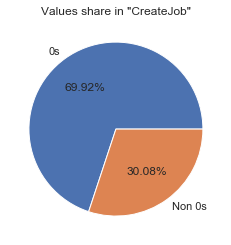

In [24]:
#getting the count of zero and non zero values in the column 'CreateJob'
values = [data[data.CreateJob == 0].shape[0], data.shape[0]-data[data.CreateJob == 0].shape[0]]

#providing the labels
labels = ['0s', 'Non 0s']

#plotting a pie plot to see the distribution
plt.pie(x = values, labels = labels, autopct = '%.2f%%')
plt.title('Values share in "CreateJob"')
plt.show()

### Since a greater percentage of values in 'CreateJob' column are 0, thus dropping the column

In [25]:
data.drop('CreateJob', axis = 1, inplace = True)

## RetainedJob

In [26]:
data.RetainedJob.value_counts()

0       432529
1        87236
2        75842
3        49290
4        39161
         ...  
3860         1
199          1
585          1
1300         1
191          1
Name: RetainedJob, Length: 356, dtype: int64

### Visualizing the value share between zero and non zero values in 'ReatinedJob'

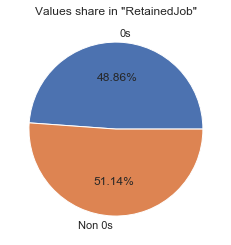

In [27]:
#getting the count of zero and non zero values in the column 'RetainedJob'
values = [data[data.RetainedJob == 0].shape[0], data.shape[0]-data[data.RetainedJob == 0].shape[0]]

#providing the labels
labels = ['0s', 'Non 0s']

#plotting a pie plot to see the distribution
plt.pie(x = values, labels = labels, autopct = '%.2f%%')
plt.title('Values share in "RetainedJob"')
plt.show()

### There is almost equal share of zero and non zero values, thus keeping 'RetainedJobs' column. 

## UrbanRural

### According to the documentation there should only be two values, 1 (Urban) and 2(Rural).

In [28]:
data.UrbanRural.value_counts()

1    464786
0    316514
2    103919
Name: UrbanRural, dtype: int64

### Visualising the value distribution in 'UrbanRural'

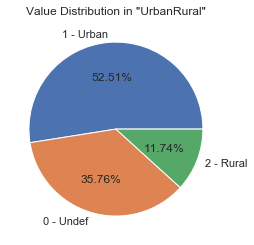

In [29]:
#getting the values
x = data.UrbanRural.value_counts().to_numpy()

#plotting the chart
plt.pie(x, labels = ['1 - Urban', '0 - Undef', '2 - Rural'], autopct = '%.2f%%')
plt.title('Value Distribution in "UrbanRural"')
plt.show()

#### Further analysing on the basis of 'MIS_Status'

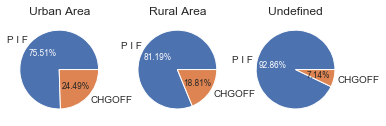

In [30]:
f, ax = plt.subplots(1, 3)

#A function to plot the subplots for each area
def custom_plot(data, area_code, area_name, index, ax):
    #getting the data in related to the area
    t = data[data.UrbanRural == area_code].MIS_Status.value_counts()
    
    #providing the title to the plot
    ax[index].title.set_text(area_name)
    
    #plotting
    patches, text, autotexts = ax[index].pie(t, labels = ['P I F', 'CHGOFF'], autopct = '%.2f%%', textprops = {'size' : 'smaller'})
    plt.setp(autotexts, size='x-small')
    autotexts[0].set_color('white')
    return

#for 'Urban Area'
custom_plot(data, 1, 'Urban Area', 0, ax)

#for 'Rural Area'
custom_plot(data, 2, 'Rural Area', 1, ax)

#for 'Undefined'
custom_plot(data, 0, 'Undefined', 2, ax)

#displaying
plt.show()

### From the above analysis, it is inferred that keeping this column would lead to a misinformed model. Thus dropping it.

In [31]:
data.drop('UrbanRural', axis = 1, inplace = True)

## RevLineCr

### According to the documentation it can have only two values either 'Y' or 'N'.

In [32]:
#getting all the values in the column
data.RevLineCr.value_counts()

N    414512
0    257307
Y    198236
T     15100
1        22
R        14
`        11
2         6
C         2
4         1
3         1
-         1
A         1
Q         1
.         1
,         1
7         1
5         1
Name: RevLineCr, dtype: int64

### Origanally the values in this column should be either Y or N which should be converted to 1 or 0 respectively. On the keyboard keys 'T' & 'R' are just next to 'Y', thus assuming 'T' & 'R' to be 'Y' and 0 to be 'N', also 1 to be 'Y'. Removing other values.

In [33]:
#a dictionary to map entries to 0 and 1
correct = {'N' : 0, 'Y' : 1, '1' : 1, '0' : 0, 'T' : 1, 'R' : 1}

#correcting the values
for i in correct:
    data.loc[data.RevLineCr == i, 'RevLineCr'] = correct[i]
    
data.RevLineCr.value_counts()

0    671819
1    213372
`        11
2         6
C         2
4         1
,         1
3         1
-         1
A         1
Q         1
.         1
7         1
5         1
Name: RevLineCr, dtype: int64

In [34]:
#dropping the values which are not 0 or 1
data.drop(data[(data.RevLineCr != 0) & (data.RevLineCr != 1)].index, inplace = True)
data.reset_index(inplace = True, drop = True)

## LowDoc

### According to the documentation it can have only two values either 'Y' or 'N'.

In [35]:
data.LowDoc.value_counts()

N    774279
Y    107760
0      1235
C       752
S       598
A       492
R        74
1         1
Name: LowDoc, dtype: int64

### Assuming 'R' to be 'Y' and 0 to be 'N', also 1 to be 'Y'. Removing other values.

In [36]:
#correcting the values
data.loc[data.LowDoc == 'N', 'LowDoc'] = 0
data.loc[data.LowDoc == 'Y', 'LowDoc'] = 1
data.loc[data.LowDoc == '0', 'LowDoc'] = 0
data.loc[data.LowDoc == '1', 'LowDoc'] = 1
data.loc[data.LowDoc == 'R', 'LowDoc'] = 1

In [37]:
data.LowDoc.value_counts()

0    775514
1    107835
C       752
S       598
A       492
Name: LowDoc, dtype: int64

In [38]:
#dropping the values other than 0 and 1
data.drop(data[(data.LowDoc != 0) & (data.LowDoc != 1)].index, inplace = True)
data.reset_index(inplace = True, drop = True)

## *Formating the columns related to currency*

In [39]:
#getting the columns related to currency
columns = ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']

#formating the columns
for column in columns:
    #removing the '$' sign
    x = data[column].str.replace('$', '')
    #removing the ','
    y = x.str.replace(',', '')
    #changing string to float and then to int
    y = y.astype(float)
    y = y.astype(int)
    #updating the values
    data[column] = y

## ChgOffPrinGr

In [40]:
data.ChgOffPrinGr.value_counts()

0         723719
50000       2101
10000       1856
25000       1361
35000       1339
           ...  
26919          1
31013          1
112925         1
110876         1
18166          1
Name: ChgOffPrinGr, Length: 82424, dtype: int64

### There are a large number of '0' values, further analysing.

In [41]:
#the count of zero values
print(data.ChgOffPrinGr.value_counts()[0])

#the count of rows with 'P I F' MIS_Status
print(data[data.MIS_Status == 'P I F'].shape[0])

723719
727873


### From the above expression and the variable description ( 'Charged off amount' ), it is clear that the '0' values correspond to the loans with MIS_Status as 'P I F'

## Portion

### The column SBA_Appv denotes the amount of loan gauranteed by SBA. Appending a new column whic represents the fraction of the loan gauranteed by SBA.

In [42]:
data['Portion'] = data.SBA_Appv/data.GrAppv

## FranchiseCode
### This denotes the Fanchise code of the applicant if its a franchise. Else it is either 0 or 1

In [43]:
#Changing the values to 0 if its not a Franchise
data.loc[(data.FranchiseCode == 0) | (data.FranchiseCode == 1), 'FranchiseCode'] = 0

#changing to 1
data.loc[data.FranchiseCode != 0, 'FranchiseCode'] = 1

### Visualising the column

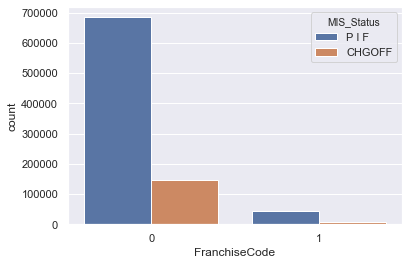

In [44]:
sns.countplot(data.FranchiseCode, hue = 'MIS_Status', data = data);

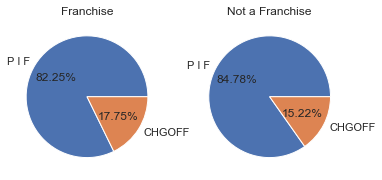

In [45]:
#making subplots
f, ax = plt.subplots(1, 2)

#a function to plot the subplots
def plot_custom(data, code, index, title):
    #getting the values
    t = data[data.FranchiseCode == code].MIS_Status.value_counts()
    #setting up
    ax[index].title.set_text(title)
    ax[index].pie(t, labels = ['P I F', 'CHGOFF'], autopct = '%.2f%%')
    return

#plotting
plot_custom(data, 0, 0, 'Franchise')
plot_custom(data, 1, 1, 'Not a Franchise')

#displaying
plt.show()

### From the above analysis it is inferred that being a Franchise or not doesn't effect the MIS_Status. Hence, excluding it from the data.

In [46]:
data.drop('FranchiseCode', axis = 1, inplace = True)

## BalanceGross

In [47]:
data.BalanceGross.value_counts()

0         883335
12750          1
25000          1
9111           1
37100          1
1760           1
96908          1
84617          1
827875         1
43127          1
600            1
115820         1
996262         1
41509          1
395476         1
Name: BalanceGross, dtype: int64

### As seen above largely values are 0 thus droping this column.

In [48]:
data.drop('BalanceGross', axis = 1, inplace = True)

## Other columns

### The below mentioned columns are not useful for predictions thus, dropping them.

In [49]:
cols_td = ['LoanNr_ChkDgt', 'Name', 'City', 'Zip', 'Bank', 'ApprovalDate', 'ApprovalFY', 'DisbursementDate']

In [50]:
data.drop(cols_td, axis = 1, inplace = True)

# Data Preprocessing for Model

In [51]:
#changing the values of the target variable as 0 and 1
data.loc[data.MIS_Status == 'P I F', 'MIS_Status'] = 1
data.loc[data.MIS_Status == 'CHGOFF', 'MIS_Status'] = 0

In [52]:
#standardizing the below mentioned columns
data[['State', 'BankState', 'NAICS', 'Term', 'NoEmp', 'RetainedJob', 'DisbursementGross', 'ChgOffPrinGr', 
           'GrAppv', 'SBA_Appv']] = StandardScaler().fit_transform(data[['State', 'BankState', 'NAICS', 'Term', 'NoEmp', 'RetainedJob', 'DisbursementGross', 'ChgOffPrinGr', 
           'GrAppv', 'SBA_Appv']])

In [53]:
#final data
data

,State,BankState,NAICS,Term,NoEmp,NewExist,RetainedJob,RevLineCr,LowDoc,DisbursementGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,RealEstate,Portion
0,0.012614,-0.221810,0.922003,-0.340947,-0.099995,2.0,-0.045593,0,1,-0.493312,1,-0.207508,-0.470426,-0.446419,0,0.80
1,0.012614,-1.069264,0.698281,-0.644797,-0.126986,2.0,-0.045593,0,1,-0.562789,1,-0.207508,-0.540987,-0.516562,0,0.80
2,0.012614,-1.069264,-1.136927,0.874453,-0.059508,1.0,-0.045593,0,0,0.295254,1,-0.207508,0.330448,0.286791,0,0.75
3,-0.486530,-0.823934,-1.463865,-0.644797,-0.126986,1.0,-0.045593,0,1,-0.580158,1,-0.207508,-0.558628,-0.534097,0,0.80
4,2.326424,-0.206192,-1.463865,1.634078,0.034962,1.0,-0.016129,0,0,0.093770,1,-0.207508,0.125820,0.347070,1,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883344,-0.259177,0.642135,0.922003,-0.644797,-0.073003,1.0,-0.045593,0,0,-0.458573,1,-0.207508,-0.435145,-0.411348,0,0.80
883345,-0.259177,0.642135,0.922003,-0.644797,-0.073003,1.0,-0.045593,1,0,-0.406465,1,-0.207508,-0.382224,-0.470531,0,0.50
883346,0.217959,0.554965,-0.620524,-0.037097,0.196911,1.0,-0.045593,0,0,0.340415,1,-0.207508,0.376313,0.329534,0,0.75
883347,-0.551536,-1.033011,-1.463865,-0.644797,-0.073003,1.0,-0.045593,0,1,-0.441204,0,0.500883,-0.417505,-0.393812,0,0.80


In [54]:
#creating Y array
Y = data.MIS_Status.astype(int)

#creating X array
X = data.drop('MIS_Status', axis = 1)
X = X.to_numpy()

In [55]:
#splitting the data into 3 parts, train, validation and test in 70:15:15 proportion respectively

#train and test split
Xtrain, Xtest, Ytrain, Ytest = model_selection.train_test_split(X, Y, test_size = 0.15, shuffle = True)

#train and validation split
Xtrain, Xval, Ytrain, Yval = model_selection.train_test_split(Xtrain, Ytrain, test_size = 0.17647, shuffle = True)

#proportions
ceil(len(Xtrain)/len(X)*100), ceil(len(Xval)/len(X)*100), int(len(Xtest)/len(X)*100)

(70, 15, 15)

# Applying Machine Learning

In [56]:
#applying a LogisticRegression Model
clf_lr = LogisticRegression(max_iter = 250)

In [57]:
#dictionary for various values of 'C' parameter
c_values = {'C' : [0.9, 0.75, 0.5, 0.33]}

#building the final classifier
clf = model_selection.GridSearchCV(estimator = clf_lr, param_grid = c_values)

In [58]:
#fitting the model
clf.fit(Xtrain, Ytrain)

#score on train set
clf.score(Xtrain, Ytrain)

0.9833620120838886

In [59]:
#score on validation set
lr_val =  clf.score(Xval, Yval)
print(lr_val)

0.9834719475932439


## The validation and training score are almost equal, hence it is a good fit model.

# Applying Deep Learning

In [60]:
#making a sequential model
model = Sequential()

In [61]:
#shape of train set
Xtrain.shape

(618344, 15)

In [62]:
#building the model

#hidden layers
layer1 = Dense(units = 64, activation = 'relu', input_dim = 15)
layer2 = Dense(units = 64, activation = 'relu')
layer3 = Dense(units = 128, activation = 'relu')

#output layer
layer4 = Dense(units = 1, activation = 'sigmoid')

#adding the layers
model.add(layer1)
model.add(layer2)
model.add(layer3)
model.add(layer4)

#using the RMS optimizer
optimizer = keras.optimizers.RMSprop(lr = 0.001, rho = 0.9, epsilon = 1e-08, decay = 0.0)

#compiling the model
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['acc'])

In [63]:
# Reducing the learning rate when validation accuracy doesn't change for 2 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',
                       patience = 2,
                       verbose = 1,
                       factor = 0.5,
                       min_lr=0.00001)

In [64]:
#fitting the train data and also calculating the validation accuracy
model.fit(Xtrain, Ytrain, epochs = 20, validation_data = (Xval, Yval), callbacks = [learning_rate_reduction])

Train on 618344 samples, validate on 132502 samples
Epoch 1/20
618344/618344 [==============================] - 38s 62us/step - loss: 0.0522 - acc: 0.9895 - val_loss: 0.0511 - val_acc: 0.9921
Epoch 2/20
618344/618344 [==============================] - 43s 69us/step - loss: 0.0544 - acc: 0.9917 - val_loss: 0.0593 - val_acc: 0.9925
Epoch 3/20
618344/618344 [==============================] - 37s 60us/step - loss: 0.0621 - acc: 0.9919 - val_loss: 0.0489 - val_acc: 0.9915
Epoch 4/20
618344/618344 [==============================] - 37s 60us/step - loss: 0.0676 - acc: 0.9920 - val_loss: 0.0589 - val_acc: 0.9922

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/20
618344/618344 [==============================] - 36s 59us/step - loss: 0.0616 - acc: 0.9924 - val_loss: 0.0541 - val_acc: 0.9925
Epoch 6/20
618344/618344 [==============================] - 36s 59us/step - loss: 0.0606 - acc: 0.9924 - val_loss: 0.0492 - val_acc: 0.9926
Epoch 7/20
618344/618344 [=

# Comparing the models

## As seen above the DeepLearning model has a validation accuracy of *99.25%* where as the Machine Learning model has *98.35%*. Although it is not a large increase but still Deeplearning model is able to perform better.

# Predicting

## since DeepLearning model is better, using it to make final predictions.

In [65]:
#predicting
prediction_proba = model.predict(Xtest)

## the model computes the probabilty of a given loan to be approved. Thus considering probabilities >= 0.5 to be predicting 1 and others 0.

In [66]:
#a list to store the predictions (0 or 1 values)
pred = []

#classifying as 0 or 1
for i in range(len(prediction_proba)):
    if(prediction_proba[i] >= 0.5):
        pred.append(1)
    else:
        pred.append(0)

## Report

### Confusion Matrix

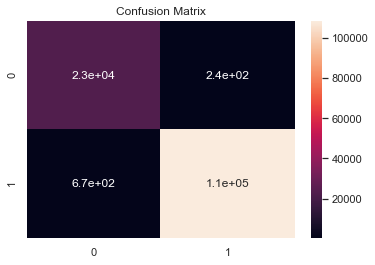

In [67]:
#confusion matrix
cm = confusion_matrix(Ytest, pred)

#confusion matrix as DataFrame
df_cm = pd.DataFrame(cm, index = ['0', '1'], columns = ['0', '1'])

#plotting Confusion Matrix
sns.heatmap(df_cm, annot = True);
plt.title('Confusion Matrix')
plt.show()

### Classification Report

In [68]:
print(classification_report(Ytest, pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     23320
           1       1.00      0.99      1.00    109183

    accuracy                           0.99    132503
   macro avg       0.98      0.99      0.99    132503
weighted avg       0.99      0.99      0.99    132503

